# Import

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from matplotlib import animation, patches
import torch
import torch.nn as nn
import numpy as np
import collections
import cv2
import pdb
from torchvision import transforms
from maskrcnn_benchmark.config import cfg
from PIL import Image
from torchvision.datasets.coco import CocoDetection
from maskrcnn_benchmark.utils import checkpoint
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.structures.image_list import *
from maskrcnn_benchmark.modeling.rpn.inference import *
from maskrcnn_benchmark.modeling.rpn.rpn import *
from maskrcnn_benchmark.modeling.rpn.anchor_generator import *
from maskrcnn_benchmark.data.transforms import build_transforms
from maskrcnn_benchmark.structures.boxlist_ops import boxlist_iou
from maskrcnn_benchmark.data.transforms import transforms as T

np.random.seed(1902)
torch.manual_seed(1902)
torch.cuda.manual_seed_all(1902)

['', '/data/works/risp/fashion/krish/github1/maskrcnn-benchmark', '/home/singhkrishna01/anaconda3/envs/maskrcnn_benchmark/lib/python37.zip', '/home/singhkrishna01/anaconda3/envs/maskrcnn_benchmark/lib/python3.7', '/home/singhkrishna01/anaconda3/envs/maskrcnn_benchmark/lib/python3.7/lib-dynload', '/home/singhkrishna01/anaconda3/envs/maskrcnn_benchmark/lib/python3.7/site-packages', '/home/singhkrishna01/anaconda3/envs/maskrcnn_benchmark/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg', '/home/singhkrishna01/anaconda3/envs/maskrcnn_benchmark/lib/python3.7/site-packages/tqdm-4.28.1-py3.7.egg', '/home/singhkrishna01/anaconda3/envs/maskrcnn_benchmark/lib/python3.7/site-packages/Pillow-5.3.0-py3.7-linux-x86_64.egg', '/home/singhkrishna01/anaconda3/envs/maskrcnn_benchmark/lib/python3.7/site-packages/pycocotools-2.0-py3.7-linux-x86_64.egg', '/data/works/risp/fashion/krish/github1/maskrcnn-benchmark', '/home/singhkrishna01/anaconda3/envs/maskrcnn_benchmark/lib/python3.7/site-packages/IPy

# Feature Extractor

loading annotations into memory...
Done (t=3.86s)
creating index...
index created!


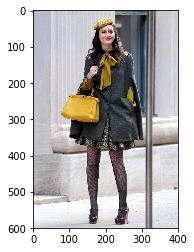

In [2]:
# Load the dataset
root = "/data/works/risp/fashion/krish/github1/maskrcnn-benchmark/datasets/modanet/images/train/"
ann_file = "/data/works/risp/fashion/krish/github1/maskrcnn-benchmark/datasets/modanet/annotations/modanet2018_instances_train.json"
idx = 101
coco = CocoDetection(root, ann_file)
img, anno = coco[idx]
# Load Config File
config_file = "/data/works/risp/fashion/krish/github1/maskrcnn-benchmark/configs/e2e_faster_rcnn_R_50_C4_1x.yaml"
cfg.merge_from_file(config_file)

# Load Trained Model
model_path = "/data/works/risp/fashion/krish/maskrcnn/models/50_new/"
weight_file = "model_0002500.pth"

# Build the model
res_50 = build_detection_model(cfg)

# Load the weights
checkpoint_obj = checkpoint.DetectronCheckpointer(cfg, res_50)
_ = checkpoint_obj.load()

# Show the image
plt.imshow(img)

In [3]:
image_size = (cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN)
def get_size(image_size):
    w, h = image_size
    size = cfg.INPUT.MIN_SIZE_TRAIN
    max_size = cfg.INPUT.MAX_SIZE_TRAIN
    if max_size is not None:
        min_original_size = float(min((w, h)))
        max_original_size = float(max((w, h)))
        if max_original_size / min_original_size * size > max_size:
            size = int(round(max_size * min_original_size / max_original_size))

    if (w <= h and w == size) or (h <= w and h == size):
        return (h, w)

    if w < h:
        ow = size
        oh = int(size * h / w)
    else:
        oh = size
        ow = int(size * w / h)

    return (oh, ow)
print(get_size(img.size))

(600, 400)


In [4]:
# Normalize the image and add make a batch of single image

def build_transforms(cfg, is_train=True):
    if is_train:
        min_size = cfg.INPUT.MIN_SIZE_TRAIN
        max_size = cfg.INPUT.MAX_SIZE_TRAIN
        flip_prob = 0.5  # cfg.INPUT.FLIP_PROB_TRAIN
    else:
        min_size = cfg.INPUT.MIN_SIZE_TEST
        max_size = cfg.INPUT.MAX_SIZE_TEST
        flip_prob = 0
# TODO: Find a way to include this.
#     to_bgr255 = is_train
#     normalize_transform = T.Normalize(
#         mean=cfg.INPUT.PIXEL_MEAN, std=cfg.INPUT.PIXEL_STD, to_bgr255=to_bgr255
#     )

    transform = T.Compose(
        [
            T.Resize(min_size, max_size),
            T.RandomHorizontalFlip(flip_prob),
            T.ToTensor(),
#             normalize_transform,
        ]
    )
    return transform

transforms = build_transforms(cfg)
json_category_id_to_contiguous_id = {
            v: i + 1 for i, v in enumerate(coco.coco.getCatIds())
        }
# This is hackish since we are calculating for those bbox's also that are outside the image.
boxes = [obj["bbox"] for obj in anno]
boxes = torch.as_tensor(boxes).reshape(-1, 4)  # guard against no boxes
target = BoxList(boxes, img.size[-2:], mode="xywh").convert("xyxy")
classes = [obj["category_id"] for obj in anno]
classes = [json_category_id_to_contiguous_id[c] for c in classes]
classes = torch.tensor(classes)
target.add_field("labels", classes)
target = target.clip_to_image(remove_empty=True)
img_transform, target_transform = transforms(img, target)
img_input = img_transform.unsqueeze(dim=0)
targets = [target]

### This is the backbone Network in the case of faster-RCNN Network.
### This network is responsible for finding the feature maps of your image.
### Generally this is an very important part since, the output of this network would be a 
### a major factor in what the subsequent network predicts.
### Idea: Instead of just using FPN can we concatenate Feature maps from diffent layers as in the 
### in the case of PolygonRNN. 

In [5]:
def get_feat(model, img):
    model.eval()
    feat = model.backbone.forward(img)[0]
    feat = feat.squeeze(dim=0)
    feat = feat.detach().numpy()
    return feat
feat_50 = get_feat(res_50, img_input)

#### This is what your network actually sees.

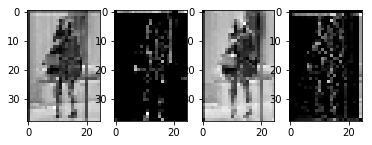

In [6]:
feat_50_1 = feat_50[64, :, :]
feat_50_2 = feat_50[128, :, :]
feat_50_3 = feat_50[256, :, :]
feat_50_4 = feat_50[1022, :, :]
plt.subplot(1,4,1)
plt.imshow(feat_50_1, cmap='gray')
plt.subplot(1,4,2)
plt.imshow(feat_50_2, cmap='gray')
plt.subplot(1,4,3)
plt.imshow(feat_50_3, cmap='gray')
plt.subplot(1,4,4)
plt.imshow(feat_50_4, cmap='gray')

#### RPN Network

##### Mechanism:
* *Step 1*: Generate anchor boxes. Anchor boxes are your bounding boxes this is what would give the
        eventual RPN network to refine your bbox predictions.

* *Step 2*: You want to have bounding boxes here that are of diffrent orientations and sizes since we 
        are not sure what shape of the object bounding box this contains.

In [7]:
def draw_anchors(img, anchors, save_interval=0, save_dir="./gif"):
    img_t = img.copy()
    img = img_t.copy()
    if not os.path.exists(save_dir):
        os.makedirs(save_dir);
    if anchors.ndim == 1:
        anchors = anchors[None, :]
    for idx, anchor in enumerate(anchors):
        img = cv2.rectangle(img, (anchor[0], anchor[1]), (anchor[2], anchor[3]), (0, 255, 0), 2)
        if save_interval and idx % save_interval==0:
            plt.imsave(os.path.join(save_dir, f"canvas_{idx}"), img)
            img = img_t.copy()
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


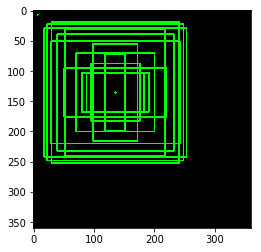

In [8]:
canvas = np.zeros((360, 360, 3)) # Just a blank canvas to draw on.
cell_anchors = res_50.rpn.anchor_generator.cell_anchors._buffers['0'][:, ...]
anchors = cell_anchors.clone().numpy().astype(np.uint8)
canvas = draw_anchors(canvas, anchors)
# cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
plt.imshow(canvas)

In [9]:
def grid_anchors(grid_sizes, strides, cell_anchors):
    anchors = []
    for size, stride, base_anchors in zip(
        grid_sizes, strides, cell_anchors
    ):
        grid_height, grid_width = size
        device = base_anchors.device
        shifts_x = torch.arange(
            0, grid_width * stride, step=stride, dtype=torch.float32, device=device
        )
        shifts_y = torch.arange(
            0, grid_height * stride, step=stride, dtype=torch.float32, device=device
        )
        shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x)
        shift_x = shift_x.reshape(-1)
        shift_y = shift_y.reshape(-1)
        shifts = torch.stack((shift_x, shift_y, shift_x, shift_y), dim=1)

        anchors.append(
            (shifts.view(-1, 1, 4) + base_anchors.view(1, -1, 4)).reshape(-1, 4)
        )

    return anchors


In [10]:
canvas = img_input.squeeze().permute(1, 2, 0).clone().numpy()
image_height, image_width = canvas.shape[:-1]
anchor_generator = make_anchor_generator(config=cfg)
anchors = grid_anchors((feat_50.shape[-2:], ), anchor_generator.strides, anchor_generator.cell_anchors)[0]
anchors_boxlist = BoxList(anchors, (image_width, image_height), mode="xyxy")# Take care image_width, image_height
straddle_thresh = anchor_generator.straddle_thresh


anchors_bbox = anchors_boxlist.bbox
inds_inside = (
    (anchors_bbox[..., 0] >= -straddle_thresh)
    & (anchors_bbox[..., 1] >= -straddle_thresh)
    & (anchors_bbox[..., 2] < image_width + straddle_thresh)
    & (anchors_bbox[..., 3] < image_height + straddle_thresh)
)
anchors_boxlist.add_field("visibility", inds_inside)
visible_bbox = anchors_bbox[inds_inside]

*Image placing thesee bounding box over the original image, and think about how the network can refine these predictions*

In [11]:
# ONLY RUN ONCE
# Overlay of the bboxes on the feat images.
visible_bbox_np = visible_bbox.clone().numpy()
canvas = draw_anchors(canvas, visible_bbox_np, 50)

#### Creates a anchor for every position in the image for the given features. 
####  Similar to how a feature moves 
####  The RPN networks takes in the features and images. 
####  The RPN Head computes the objectedness score for each feature.[Each Feature]
####  THe RPN network then generates same base cell anchors which are of the size of stride length. The cell anchors are
####  positioned at (0, 0). Now we want these anchors for each location in the image. Moving with stride length. That's 
####  how we get 56250 ==> 75*50*15 Anchor boxes. Now rember that these boxes in general to do not reprsent anything. They weren't learn rember(Duh!!!)
####  Now there maybe anchors not inside the image we disergard these boxes.

**Now suppose that these anchor boxes are moved around the whole image. Some anchors are   not inside of the image and we ignore them. We want to create such anchors for all 
features of a image. Because the object may be only activating a particular channel.**


In [12]:
# import io
# import base64
# from IPython.display import HTML

# video = io.open('./dynamic_images.mp4', 'r+b').read()
# encoded = base64.b64encode(video)
# HTML(data="""<video alt="test" controls>
#                 <source src="data:video/mp4;base64,{0}" type="video/mp4" />
#              </video>""".format(encoded.decode('ascii')))

**The next bit is a bit tricky.**
** The RPN network head is a convext which outputs 2 things.**
** The objectness score (There is object or not) and the Co-ordinates of the bounding boxes.**
**Now for the whole feature map we just need to output the co-ordinates for num_anchors boxes.**
**Why is that so? In essence the RPN network is actually taking the feature map and pointing out okay* these num_anchors(15) positions are the best **
**Why did we compute the all above anchors boxes(for each x,y ). Well we need to find the which anchors best match with predicted anchors **

# RPN Head

In [13]:
# The RPN Head. The RPN Head is your usually CNN it computes the Bounding box regression
# and classification for score for each of the feature map's.
feat = res_50.backbone(img_input)
objectness, rpn_box_regression = res_50.rpn.head(feat)
print(objectness[0].shape) 
print(rpn_box_regression[0].shape)
# Why list is returned, because we could also have a FPN model. Where objectness and rpn_box_regresson
# are computed at different levels. In this example we have only 1 level.
# Here we are prediciting bbox regression values for each of the pixel in the feat network.
# this is also equivalent to the number of anchors. similarly for the objecteness values. 

torch.Size([1, 15, 38, 25])
torch.Size([1, 60, 38, 25])


# Match Quality Matrix

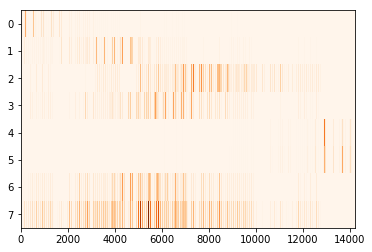

In [14]:
# Matchers find the box IOU overlaps between the ground thruth and the anchors that we generate previously.
match_quality_matrix = boxlist_iou(anchors_boxlist, target) # number of gt boxes is 8 for this image
plt.imshow(match_quality_matrix.transpose(0, 1), cmap='Oranges', aspect='auto')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Most Matched Category Label: footwear


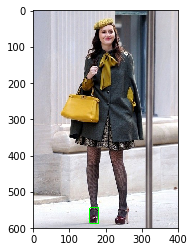

In [15]:
# As we can see that there are only a small number of matches. The darker the color indicates stronger
# the match. Some conclusions can be drawn from this already.
# A lot of proposal match the 4 gT Bounding box. 
print("Most Matched Category Label:", coco.coco.cats[target.get_field('labels')[4].item()]['name'])
img_transform_ = img_transform.permute(1, 2, 0).numpy()
x1, y1, x2, y2 = target_transform.bbox[4].numpy()
canvas = img_transform_.copy()
canvas = cv2.rectangle(canvas, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(canvas)

# Matcher

In [16]:
# Now let's seperate the good matches from the bad.
allow_low_quality_matches = True
high_threshold = cfg.MODEL.RPN.FG_IOU_THRESHOLD
low_threshold = cfg.MODEL.RPN.BG_IOU_THRESHOLD 
# The matcher module does this task by assigning to each bbox a score score base on the matching matrix.
print(match_quality_matrix.shape)
pos_idxs = []
neg_idxs = []
matched_vals, matches = match_quality_matrix.max(dim=1)
if allow_low_quality_matches: # allow low quality matches. (I will explain this in a bit)
    cloned_matches = matches.clone()

# Assign candidate matches with low quality to negative (unassigned) values
below_low_threshold = matched_vals < low_threshold
between_thresholds = (matched_vals >= low_threshold) & (matched_vals < high_threshold)
matches[below_low_threshold] = -1
matches[between_thresholds] = -2

torch.Size([14250, 8])


In [17]:
# There might be some gT boxes without a single match.
tmp_matches = matches.clamp(0)
zero_val = np.setdiff1d(torch.arange(0, 7).numpy(), tmp_matches[torch.nonzero(matches)].unique().numpy())
for i in zero_val:
    print("No good matches for", coco.coco.cats[target.get_field('labels')[i].item()]['name'])

# While training we can't be too strict with our network. We need to find ways to reward it
# even if predicts somewhat correctly. Moreover, # TODO write how this would effect the loss value.

# Let's allow low quality matches.
# if allow_low_quality_matches:
#     set_low_quality_matches_(matches, all_matches, match_quality_matrix)

# For each gt, find the prediction with which it has highest quality
highest_quality_foreach_gt, _ = match_quality_matrix.max(dim=0) 

# Find highest quality match available, even if it is low, including ties
gt_pred_pairs_of_highest_quality = torch.nonzero(
    match_quality_matrix.transpose(0, 1) == highest_quality_foreach_gt[:, None]
)
pred_inds_to_update = gt_pred_pairs_of_highest_quality[:, 1]
matches[pred_inds_to_update] = cloned_matches[pred_inds_to_update]

print("----------------")
tmp_matches = matches.clamp(0)
zero_val = np.setdiff1d(torch.arange(0, 7).numpy(), tmp_matches[torch.nonzero(matches)].unique().numpy())
for i in zero_val:
    print("No good matches for", coco.coco.cats[target.get_field('labels')[i].item()]['name'])


No good matches for scarf/tie
No good matches for footwear
----------------


# Discarding some matches

In [18]:
matched_targets = target[matches.clamp(min=0)] # Just copy all the labels that had a match. 
matched_targets.add_field("matched_idxs", matches)
matched_idxs = matched_targets.get_field("matched_idxs")
# This is little sneaky. Here labels_per_image indicates the positions where there are matches.
# It is sneakt because soon we found of getting background's implicitly without doing much.
# We just need to discard indices that are between threshold.
labels_per_image = matched_idxs >= 0
labels_per_image = labels_per_image.to(dtype=torch.float32)
# discard anchors that go out of the boundaries of the image
labels_per_image[~anchors_boxlist.get_field("visibility")] = -1

# discard indices that are between thresholds
inds_to_discard = matched_idxs == -2
labels_per_image[inds_to_discard] = -1

# Fg/Bg Sampler

In [19]:
# fg/bg samplers need to balanced. Since there is high imbalance betweeen the fg and bg bounding boxes
fg = len(torch.nonzero(labels_per_image>0)) # foreground/ positive_Samples
bg = len(torch.nonzero(labels_per_image==0)) # background / negative_samples
print(f"Ratio between foreground and background is {fg/bg}")
# As can been seen this is abysmal. If we randomly sample fg and bg samples fromn this
# we would be getting very low number of positive samples, hindering the perfomance of the
# model. Since, it would only learn the background information.

Ratio between foreground and background is 0.00537261698440208


In [20]:
# Let's do balanced sampling. fg/bg sampler
positive_fraction = 0.7 # 1/3 sampling is done here.
batch_size_per_image = cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE
positive_samples = []
negative_samples = []
positive = torch.nonzero(labels_per_image >= 1).squeeze(1)
negative = torch.nonzero(labels_per_image == 0).squeeze(1)

num_pos = int(batch_size_per_image * positive_fraction)
# protect against not enough positive examples
num_pos = min(positive.numel(), num_pos)
num_neg = batch_size_per_image - num_pos
# protect against not enough negative examples
num_neg = min(negative.numel(), num_neg)

# randomly select positive and negative examples
perm1 = torch.randperm(positive.numel(), device=positive.device)[:num_pos]
perm2 = torch.randperm(negative.numel(), device=negative.device)[:num_neg]

pos_idx_per_image = positive[perm1]
neg_idx_per_image = negative[perm2]

# create binary mask from indices
pos_idx_per_image_mask = torch.zeros_like(
    labels_per_image, dtype=torch.uint8
)
neg_idx_per_image_mask = torch.zeros_like(
    labels_per_image, dtype=torch.uint8
)
pos_idx_per_image_mask[pos_idx_per_image] = 1
neg_idx_per_image_mask[neg_idx_per_image] = 1

positive_samples.append(pos_idx_per_image_mask)
negative_samples.append(neg_idx_per_image_mask)


In [21]:
sampled_pos_inds = torch.nonzero(torch.cat(positive_samples, dim=0)).squeeze(1)
sampled_neg_inds = torch.nonzero(torch.cat(negative_samples, dim=0)).squeeze(1)
sampled_inds = torch.cat([sampled_pos_inds, sampled_neg_inds], dim=0)

# Box Coder

In [22]:
# Let's talk about the box coder. In the case of all object detection modules.
# Rather than learning the direct co-ordinates. We instead learn transformations 
# that convert the predicted and gt bbox's. 
# Box-Coder converts between x1,y1,x2,y2 to x_ctr, y_ctr, w, h.
# We learn the transformations rather than learning discrete point's. I feel the reason for this
# is that, NN are function approximators, so it is better to learn the transformation functions 
# rather than learning discrete representations.

def box_coder_encode(reference_boxes, proposals):
    TO_REMOVE = 1  # TODO remove
    ex_widths = proposals[:, 2] - proposals[:, 0] + TO_REMOVE
    ex_heights = proposals[:, 3] - proposals[:, 1] + TO_REMOVE
    ex_ctr_x = proposals[:, 0] + 0.5 * ex_widths
    ex_ctr_y = proposals[:, 1] + 0.5 * ex_heights

    gt_widths = reference_boxes[:, 2] - reference_boxes[:, 0] + TO_REMOVE
    gt_heights = reference_boxes[:, 3] - reference_boxes[:, 1] + TO_REMOVE
    gt_ctr_x = reference_boxes[:, 0] + 0.5 * gt_widths
    gt_ctr_y = reference_boxes[:, 1] + 0.5 * gt_heights

    wx, wy, ww, wh = (1, 1, 1, 1)
    targets_dx = wx * (gt_ctr_x - ex_ctr_x) / ex_widths
    targets_dy = wy * (gt_ctr_y - ex_ctr_y) / ex_heights
    targets_dw = ww * torch.log(gt_widths / ex_widths)
    targets_dh = wh * torch.log(gt_heights / ex_heights)

    targets = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh), dim=1)
    return targets


def box_coder_decode(rel_codes, boxes):
    bbox_xform_clip = math.log(1000. / 16)
    boxes = boxes.to(rel_codes.dtype)

    TO_REMOVE = 1  # TODO remove
    widths = boxes[:, 2] - boxes[:, 0] + TO_REMOVE
    heights = boxes[:, 3] - boxes[:, 1] + TO_REMOVE
    ctr_x = boxes[:, 0] + 0.5 * widths
    ctr_y = boxes[:, 1] + 0.5 * heights

    wx, wy, ww, wh = [1, 1, 1, 1]
    dx = rel_codes[:, 0::4] / wx
    dy = rel_codes[:, 1::4] / wy
    dw = rel_codes[:, 2::4] / ww
    dh = rel_codes[:, 3::4] / wh

    # Prevent sending too large values into torch.exp()
    dw = torch.clamp(dw, max= bbox_xform_clip)
    dh = torch.clamp(dh, max= bbox_xform_clip)

    pred_ctr_x = dx * widths[:, None] + ctr_x[:, None]
    pred_ctr_y = dy * heights[:, None] + ctr_y[:, None]
    pred_w = torch.exp(dw) * widths[:, None]
    pred_h = torch.exp(dh) * heights[:, None]

    pred_boxes = torch.zeros_like(rel_codes)
    # x1
    pred_boxes[:, 0::4] = pred_ctr_x - 0.5 * pred_w
    # y1
    pred_boxes[:, 1::4] = pred_ctr_y - 0.5 * pred_h
    # x2 (note: "- 1" is correct; don't be fooled by the asymmetry)
    pred_boxes[:, 2::4] = pred_ctr_x + 0.5 * pred_w - 1
    # y2 (note: "- 1" is correct; don't be fooled by the asymmetry)
    pred_boxes[:, 3::4] = pred_ctr_y + 0.5 * pred_h - 1

    return pred_boxes

# These indicate the box regression targets. 
# We compute the regression targets/ transformations for each of the bounding boxes.
# For calculating the targets for the regression, we use the foreground anchor and the closest ground truth object and calculate the correct \DeltaΔ needed to transform the anchor into the object.
regression_targets_per_image = box_coder_encode(
            matched_targets.bbox, 
            anchors_boxlist.bbox
        )

## As you can see, we learn the following 4 transformations 
-- 
    - gt_ctr_x = pred_ctr_x + pred_width * d1(x)
    - gt_ctr_y = pred_ctr_y + pred_width * d2(x)
    - gt_width = pred_width * exp(d3)
    - gt_height = pred_height * exp(4)
The first transformations are easy to understand. We want to do a scale invariant transformation.
We learn to find a by what margin is the predicted center off from the gt center in the transformed space.

The next transformation is log transformation. The log transformation is usually used in the case 
when there is right skeweness in the data. p/q  y is somewhere between 0 and infinity, or in the last case, between
1 and infinity. If p = q, then y = 1. Such definitions often lead to
skewed data, because there is a clear lower limit and no clear upper
limit. The logarithm, however, namely


    log y = log p / q = log p - log q,


is somewhere between -infinity and infinity and p = q means that log y =
0. Hence the logarithm of such a ratio is likely to be more symmetrically
distributed.

# Compute the loss value

In [23]:
def smooth_l1_loss(input, target, beta=1. / 9, size_average=True):
    """
    very similar to the smooth_l1_loss from pytorch, but with
    the extra beta parameter
    """
    n = torch.abs(input - target)
    cond = n < beta
    loss = torch.where(cond, 0.5 * n ** 2 / beta, n - 0.5 * beta)
    if size_average:
        return loss.mean()
    return loss.sum()

# Let's finally compute the loss values.
objectness_flattened = []
box_regression_flattened = []
labels = [labels_per_image] # TODO: Change this to something more beautiful
regression_targets = [regression_targets_per_image] # TODO: Change this to something more beautiful
# for each feature level, permute the outputs to make them be in the
# same format as the labels. Note that the labels are computed for
# all feature levels concatenated, so we keep the same representation
# for the objectness and the box_regression
for objectness_per_level, box_regression_per_level in zip(
    objectness, rpn_box_regression
): 
    N, A, H, W = objectness_per_level.shape
    objectness_per_level = objectness_per_level.permute(0, 2, 3, 1).reshape(
        N, -1
    )
    box_regression_per_level = box_regression_per_level.view(N, -1, 4, H, W)
    box_regression_per_level = box_regression_per_level.permute(0, 3, 4, 1, 2)
    box_regression_per_level = box_regression_per_level.reshape(N, -1, 4)
    objectness_flattened.append(objectness_per_level)
    box_regression_flattened.append(box_regression_per_level)
# concatenate on the first dimension (representing the feature levels), to
# take into account the way the labels were generated (with all feature maps
# being concatenated as well)
_objectness = cat(objectness_flattened, dim=1).reshape(-1)
box_regression = cat(box_regression_flattened, dim=1).reshape(-1, 4)

labels = torch.cat(labels, dim=0)
regression_targets = torch.cat(regression_targets, dim=0)

# only those minibatch anchors marked as foreground to calculate the regression loss.
box_loss = smooth_l1_loss(
    box_regression[sampled_pos_inds],
    regression_targets[sampled_pos_inds],
    beta=1.0 / 9,
    size_average=False,
) / (sampled_inds.numel())

objectness_loss = F.binary_cross_entropy_with_logits(
    _objectness[sampled_inds], labels[sampled_inds]
)

losses = {
    "loss_objectness":  objectness_loss,
    "loss_rpn_box_reg": box_loss,
}

print(f"Objecteness Loss{objectness_loss}, Box Loss {box_loss}")

Objecteness Loss0.6925307512283325, Box Loss 0.02789723500609398


# NMS Vs SoftNms

In [24]:
# Let's discuss about the NMS part of the training now.
# NMS is non maximum supression it is used for suprresing overlapping bounding boxes nad chossing the
# best one.
# NMS for reducting the anchors that overlap each other. Let's visualise this.
pre_nms_top_n = cfg.MODEL.RPN.PRE_NMS_TOP_N_TRAIN
post_nms_top_n = cfg.MODEL.RPN.POST_NMS_TOP_N_TRAIN 
nms_thresh = cfg.MODEL.RPN.NMS_THRESH
min_size = cfg.MODEL.RPN.MIN_SIZE

In [25]:
if not isinstance(anchors_boxlist, (list)):
    list_list_anchors_boxlist = [[anchors_boxlist]] # Since we have only one image this satisfies
    anchors = list(zip(*list_list_anchors_boxlist))
if not isinstance(objectness, (list)):
   rpn_objectness = [objectness]
else: 
    rpn_objectness = objectness
    
rpn_box_regression = rpn_box_regression # dummy assignment(we already got them from the rpn head module)
sampled_boxes = []

for anchors, objectness, box_regression in zip(anchors, rpn_objectness, rpn_box_regression):
    N, A, H, W = objectness.shape

    # put in the same format as anchors
    objectness_flattened = objectness.permute(0, 2, 3, 1).reshape(N, -1)
    objectness_flattened_probs = objectness_flattened.sigmoid()
    box_regression = box_regression.view(N, -1, 4, H, W).permute(0, 3, 4, 1, 2)
    box_regression = box_regression.reshape(N, -1, 4)

    num_anchors = A * H * W

    pre_nms_top_n = min(pre_nms_top_n, num_anchors)
    print(pre_nms_top_n)
    objectness_topk, topk_idx = objectness_flattened_probs.topk(pre_nms_top_n, dim=1, sorted=True)

    batch_idx = torch.arange(N)[:, None]
    box_regression = box_regression[batch_idx, topk_idx]

    image_shapes = [box.size for box in anchors]
    concat_anchors = torch.cat([a.bbox for a in anchors], dim=0)
    concat_anchors = concat_anchors.reshape(N, -1, 4)[batch_idx, topk_idx]

    proposals = box_coder_decode(
        box_regression.view(-1, 4), concat_anchors.view(-1, 4)
    )

    proposals = proposals.view(N, -1, 4)
    
    result = []
    for proposal, score, im_shape in zip(proposals, objectness_topk, image_shapes):
        boxlist = BoxList(proposal, im_shape, mode="xyxy")
        boxlist.add_field("objectness", score)
        boxlist = boxlist.clip_to_image(remove_empty=False)
        boxlist = remove_small_boxes(boxlist, min_size)
        boxlist = boxlist_nms(
            boxlist,
            nms_thresh,
            max_proposals=post_nms_top_n,
            score_field="objectness",
        )
        result.append(boxlist)
    sampled_boxes.append(result)

# concat all box list on dim=0
boxlists = list(zip(*sampled_boxes))
boxlists = [cat_boxlist(boxlist) for boxlist in boxlists]

# copy the target boxlist without any fields
gt_boxes = [target.copy_with_fields([]) for target in targets]

# later cat of bbox requires all fields to be present for all bbox
# so we need to add a dummy for objectness that's missing
for gt_box in gt_boxes:
    gt_box.add_field("objectness", torch.ones(len(gt_box)))

proposals = [
    cat_boxlist((proposal, gt_box))
    for proposal, gt_box in zip(boxlists, gt_boxes)
]
print(proposals)# now we have the number of bbox= becuase of the 8 gt bboxs.

12000
[BoxList(num_boxes=2008, image_width=400, image_height=600, mode=xyxy)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


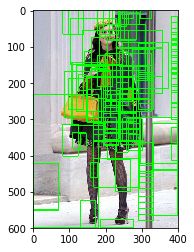

In [26]:
#Let's visulaize what box nms is doing
area_min = 1000
area = lambda x1, y1, x2, y2: (x2-x1) * (y2-y1)
remove_small_boxes_local = lambda box: box if area(*box) > area_min else None

proposals_np = result[0].bbox.squeeze().clone().detach().numpy()
canvas = img_transform_.copy()
for proposal_np in proposals_np[1900:1999]:
    canvas = cv2.rectangle(canvas,\
                           (proposal_np[0],proposal_np[1]),\
                           (proposal_np[2],proposal_np[3]),(0,255,0),\
                           2).copy()
plt.imshow(canvas)
# We can see many boxes are overlapping with the each other. Let's remove some of these boxes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


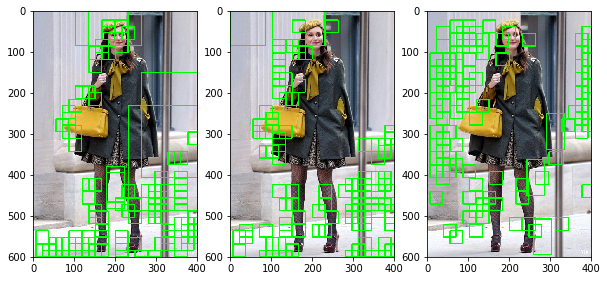

In [27]:
# As can be seen from the below example. NMS suppress those boxes that have hight overlap with each other.
# We can see as we keep on decreasing the NMS threshold the number of boxes keep going down.
# And we are left with well seperated boxes.
def nms_demo(thresh, canvas, result):
    boxlist = boxlist_nms(
        result[0],
        thresh,
        score_field="objectness",
    )
    proposals_np = boxlist.bbox.squeeze().clone().detach().numpy()
    for proposal_np in proposals_np[100:200]:
        canvas = cv2.rectangle(canvas,\
                               (proposal_np[0],proposal_np[1]),\
                               (proposal_np[2],proposal_np[3]),(0,255,0),\
                               2).copy()
    return canvas

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

for idx, thres in enumerate((0.8, 0.4, 0.2)):
    canvas = img_transform_.copy()
    axs[idx].imshow(nms_demo(thres, canvas, result))

In [28]:
# All NMS does is suppresses bounding box whoe's iou with each other is
# greater than threshold. We need to take into account the score of the function
# as we want to keep the box with the highest score from all the overlapping boxes.
# I implemented a scrappy version of nms for this purpose.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


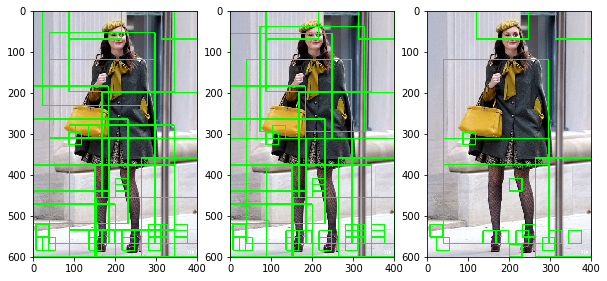

In [29]:
# Let's look at the dummy code for nms.
def compute_ovr(bboxi, bboxj):
    xx1 = max(bboxi[0], bboxj[0])
    xx2 = min(bboxi[2], bboxj[2])
    yy1 = max(bboxi[1], bboxj[1])
    yy2 = min(bboxi[3], bboxj[3])
    inter = max(0, (xx2-xx1 + 1) * (yy2 - yy1 + 1))
    areai = (bboxi[2] - bboxi[0] + 1) * (bboxi[3] - bboxi[1] + 1)
    areaj = (bboxj[2] - bboxj[0] + 1) * (bboxj[3] - bboxj[1] + 1)
    return inter / (areai + areaj - inter)
    
def nms(bboxlist, thresh, score_field):
    ign_list = []
    order, order_idx = torch.sort(score_field)
    for idxi in range(len(bboxlist)):
        if order_idx[idxi] in ign_list:
            continue
        bboxlisti = bboxlist[order_idx[idxi]]
        for idxj in range(idxi+1, len(bboxlist)):
            bboxlistj = bboxlist[order_idx[idxj]]
            if order_idx[idxj] in ign_list:
                continue
            ovr = compute_ovr(bboxlisti, bboxlistj)
            if ovr.item() >= thresh:
                ign_list.append(order_idx[idxj])
    assert(len(torch.stack(ign_list, dim=0)) == len(torch.stack(ign_list, dim=0).unique()))
    return ign_list

def nms_demo_local(thresh, canvas, result):
    result_bbox = result[0].bbox[0:100]
    result_objectness = result[0].get_field("objectness")[0:100]
    ign_list = torch.stack(nms(
        result_bbox,
        thresh,
        result_objectness,
    )).numpy()
    for idx, proposal_np in enumerate(result_bbox):
        if (idx not in ign_list):
            canvas = cv2.rectangle(canvas,\
                                   (proposal_np[0],proposal_np[1]),\
                                   (proposal_np[2],proposal_np[3]),(0,255,0),\
                                   2).copy()
    return canvas

fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

for idx, thresh in enumerate((0.6, 0.5, 0.2)):
    canvas = img_transform_.copy()
    canvas = nms_demo_local(thresh, canvas, result)
    ax[idx].imshow(canvas)

## There is another implementation which is very popular and is called the SOFTNMS.
## Let's describe the soft version of NMS.
```python 
if ovr > thresh:
    score[i] = score[i] * exp(-ovr / sigma)
```
## This is diffrent than the case of the NMS which says
```python
if ovr > thresh:
    score[i] =0
```

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


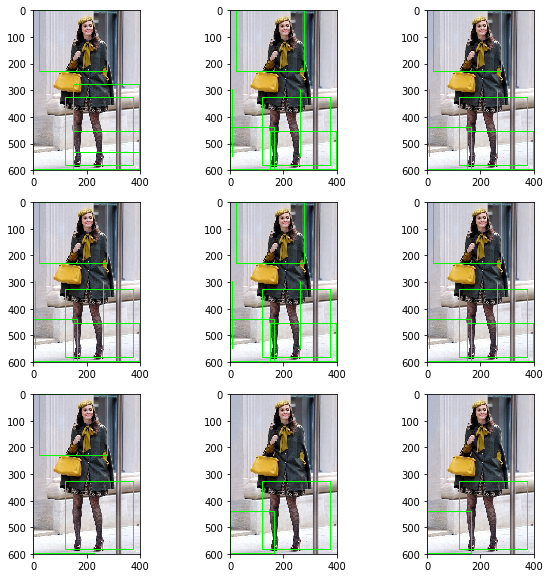

In [30]:
# Let's look at the dummy code for nms.
def soft_nms(bboxlist, score_field, nms_thresh, thresh, method, sigma):
    if isinstance(bboxlist, torch.Tensor):
        bboxlist = bboxlist.clone().detach().numpy()
        score_field = score_field.clone().detach().numpy()
    ndets = len(bboxlist)
    i = 0 
    while i < ndets:
        max_bbox_idx = np.argmax(score_field[i:ndets])
        # print(f"max_bbox_idx{i+max_bbox_idx}")
        bboxlist[i], bboxlist[i+max_bbox_idx] = bboxlist[i+max_bbox_idx], bboxlist[i]
        score_field[i], score_field[i+max_bbox_idx] = score_field[i+max_bbox_idx], score_field[i]
        p = i+1
        while p<ndets:
            ovr = compute_ovr(bboxlist[i], bboxlist[p])
            if method==1:
                if ovr >= nms_thresh:
                    score_field[p] = score_field[p] * (1 - ovr) # linear
            elif method==2:
                    score_field[p] = score_field[p] * np.exp(-((ovr*ovr) / sigma)) # gaussian
            else:
                if ovr >= nms_thresh:
                    score_field[p] = 0 # default nms
            if score_field[p] < thresh:
                bboxlist[p], bboxlist[ndets-1]=bboxlist[ndets-1], bboxlist[p]
                score_field[p], score_field[ndets-1]=score_field[ndets-1], score_field[p]
                ndets-=1
                p-=1
            p+=1
        i+=1
    return bboxlist[:ndets]

def soft_nms_demo(nms_thresh, detection_thresh, canvas, result, method, sigma):
    result_bbox = result[0].bbox[0:10].clone()
    result_objectness = result[0].get_field("objectness")[0:10].clone()
    if method == -1:
        result_bbox_sup = result_bbox
    else:
        result_bbox_sup = soft_nms(result_bbox, result_objectness,\
                                   nms_thresh, detection_thresh,\
                                   method, sigma)
    for idx, proposal_np in enumerate(result_bbox_sup):
        canvas = cv2.rectangle(canvas,\
                       (proposal_np[0], proposal_np[1]),\
                       (proposal_np[2], proposal_np[3]), (0,255,0),\
                       2).copy()
    return canvas

fig , ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
detection_thresh = 0.2
sigma = 0.2
xx, yy = np.meshgrid([0.3, 0.2, 0.1], [1, 2, 3])

for ix in range(0, len(xx)):
    idx=0
    for thresh, method in zip(xx[ix], yy[ix]):
        canvas = img_transform_.copy()
        canvas = soft_nms_demo(thresh, detection_thresh, canvas, result, method, sigma)
        ax[ix][idx].imshow(canvas)
        idx+=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[150  70 245 230]


Text(0.5, 1.0, 'nms')

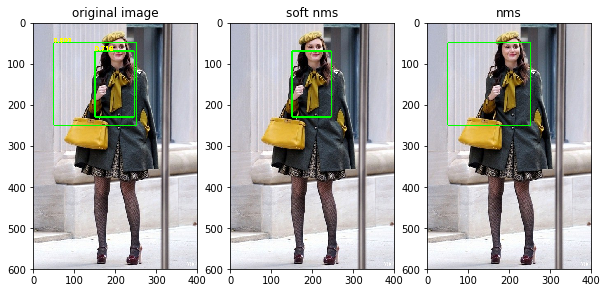

In [31]:
rect1 = np.array((50, 50, 250, 250))
rect2 = np.array((150, 70, 245, 230))
score1 = 0.501
score2 = 0.716
canvas = img_transform_.copy()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
canvas = cv2.rectangle(canvas, (rect1[0], rect1[1]), (rect1[2], rect1[3]), (0, 255, 0), 2)
canvas = cv2.putText(canvas, str(score1), (rect1[0]-1,rect1[1]-1), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 0), 2)
canvas = cv2.rectangle(canvas, (rect2[0], rect2[1]), (rect2[2], rect2[3]), (0, 255, 0), 2)
canvas = cv2.putText(canvas, str(score2), (rect2[0]-1,rect2[1]-1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)
ax[0].imshow(canvas)
ax[0].set_title("original image")
soft_nms_bbox = soft_nms([rect1, rect2], [score1, score2], 0.5, 0.45, 2, 0.9)
for rect in soft_nms_bbox:
    print(rect)
    canvas = canvas = img_transform_.copy()
    canvas = cv2.rectangle(canvas, (rect[0], rect[1]), (rect[2], rect[3]), (0, 255, 0), 2)
ax[1].imshow(canvas)
ax[1].set_title("soft nms")

original_nms_bbox = soft_nms([rect1, rect2], [score1, score2], 0.5, 0.45, 3, 0.2)
for rect in original_nms_bbox:
    canvas = canvas = img_transform_.copy()
    canvas = cv2.rectangle(canvas, (rect[0], rect[1]), (rect[2], rect[3]), (0, 255, 0), 2)
ax[2].imshow(canvas)
ax[2].set_title("nms")


# Defining ROI Align and ROIPool and Basic Diffrence between them

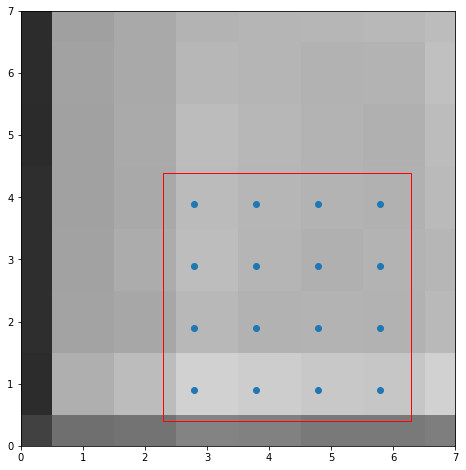

In [32]:
# Roi align 
np.random.seed(1023)
roi_pool_width, roi_pool_height = 2, 2
roi_width, roi_height = 4, 4
feature_width, feature_height = 8, 8
# Size of each bin with the pool.
bin_size_w, bin_size_h = roi_width / roi_pool_width, roi_height / roi_pool_height 
roi_bin_grid_w, roi_bin_grid_h = np.ceil(roi_width / roi_pool_width), np.ceil(roi_height / roi_pool_height)

roi_xx, roi_yy = np.meshgrid(np.arange(0, roi_height, dtype=np.float32), np.arange(0, roi_width, dtype=np.float32))
translate_x, translate_y = np.random.random()/roi_height, np.random.randn()/roi_width
roi_xx += translate_x*10
roi_yy += translate_y*10

# In the case of roi align
# What points would you be sampling.
data_points=[]
roi_start_h = roi_xx[0][0]
roi_start_w = roi_yy[0][0]
ix=0
iy=0
for ph in range(0, roi_pool_height):
    for pw in range(0, roi_pool_width):
        iy=0
        while iy < roi_bin_grid_h:
            y = roi_start_h + ph * bin_size_h + \
                (iy + .5) * bin_size_h / roi_bin_grid_h
            ix = 0
            while ix < roi_bin_grid_w:
                x = roi_start_w + pw * bin_size_w + \
                    (ix + .5) * bin_size_w / roi_bin_grid_w
                data_points.append((x, y))
                ix += 1
            iy += 1
x = [d[0] for d in data_points]
y = [d[1] for d in data_points]
# The red box indicates the roi.
# The dashed grid represents a feature vector.
fig = plt.figure(figsize=(feature_width, feature_height))
ax = fig.gca()
ax.autoscale(False)
rect = patches.Rectangle((roi_xx[0][0], roi_yy[0][0]),4,4,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.scatter(y, x) # TODO: Correct this
ax.set_xticks(np.arange(0, feature_width))
ax.set_yticks(np.arange(0, feature_height))
plt.imshow(feat_50_1, cmap='gray')


4


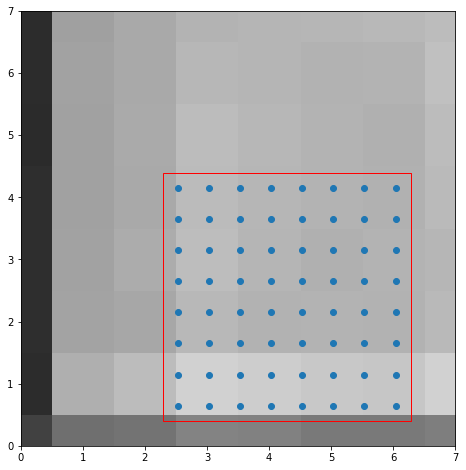

In [33]:
# Roi align with pool width >1
np.random.seed(1023)
roi_pool_width, roi_pool_height = 2, 2
roi_width, roi_height = 4, 4
feature_width, feature_height = 8, 8
# Size of each bin with the pool.
bin_size_w, bin_size_h = roi_width / roi_pool_width, roi_height / roi_pool_height 
roi_bin_grid_w, roi_bin_grid_h = 4, 4

roi_xx, roi_yy = np.meshgrid(np.arange(0, roi_height, dtype=np.float32), np.arange(0, roi_width, dtype=np.float32))
translate_x, translate_y = np.random.random()/roi_height, np.random.randn()/roi_width
roi_xx += translate_x*10
roi_yy += translate_y*10
print(roi_bin_grid_h)
# In the case of roi align
# What points would you be sampling.
data_points=[]
roi_start_h = roi_xx[0][0]
roi_start_w = roi_yy[0][0]
ix=0
iy=0
for ph in range(0, roi_pool_height):
    for pw in range(0, roi_pool_width):
        iy=0
        while iy < roi_bin_grid_h:
            y = roi_start_h + ph * bin_size_h + \
                (iy + .5) * bin_size_h / roi_bin_grid_h
            ix = 0
            while ix < roi_bin_grid_w:
                x = roi_start_w + pw * bin_size_w + \
                    (ix + .5) * bin_size_w / roi_bin_grid_w
                data_points.append((x, y))
                ix += 1
            iy += 1
x = [d[0] for d in data_points]
y = [d[1] for d in data_points]
# The red box indicates the roi.
# The dashed grid represents a feature vector.
fig = plt.figure(figsize=(feature_width, feature_height))
ax = fig.gca()
ax.autoscale(False)
rect = patches.Rectangle((roi_xx[0][0], roi_yy[0][0]),4,4,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.scatter(y, x) # TODO: Correct this
ax.set_xticks(np.arange(0, feature_width))
ax.set_yticks(np.arange(0, feature_height))
plt.imshow(feat_50_1, cmap='gray')

x_low, y_low, x_high, y_high 2 0 6 4


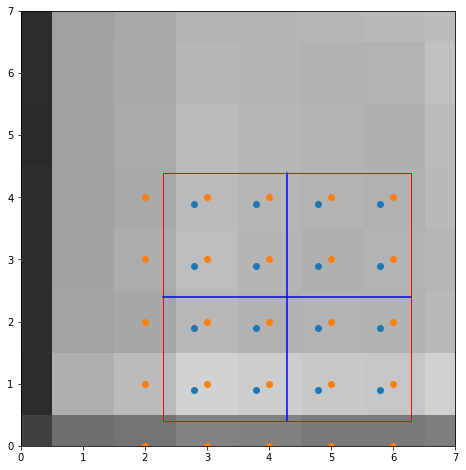

In [34]:
# The blue points are the sample points. These are the interpolated points since they do not containg the
# values. These are fractional points. The are interpolated using the four closest points. 
# We will take the case of default sampling ratio.
np.random.seed(1023)
roi_pool_width, roi_pool_height = 2, 2
roi_width, roi_height = 4, 4
feature_width, feature_height = 8, 8
# Size of each bin with the pool.
bin_size_w, bin_size_h = roi_width / roi_pool_width, roi_height / roi_pool_height 
roi_bin_grid_w, roi_bin_grid_h = np.ceil(roi_width / roi_pool_width), np.ceil(roi_height / roi_pool_height)

roi_xx, roi_yy = np.meshgrid(np.arange(0, roi_height, dtype=np.float32), np.arange(0, roi_width, dtype=np.float32))
translate_x, translate_y = np.random.random()/roi_height, np.random.randn()/roi_width
roi_xx += translate_x*10
roi_yy += translate_y*10

bilinear_data_points = []
def bilinear_interpolate_points(x, y, height, width):
    if y < -1 or y > height or x < -1 or x > width:
        # out of range, so it is empty
        return (None,) * 8

    if y <= 0:
        y = 0
    if x <= 0:
        x = 0

    y_low = int(y)
    x_low = int(x)

    if y_low >= height - 1:
        y_high = y_low = height - 1
        y = float(y_low)
    else:
        y_high = y_low + 1

    if x_low >= width - 1:
        x_high = x_low = width - 1
        x = float(x_low)
    else:
        x_high = x_low + 1

    return y_low, x_low, y_high, x_high


# In the case of roi align
# What points would you be sampling.
data_points=[]
roi_start_h = roi_xx[0][0]
roi_start_w = roi_yy[0][0]
ix=0
iy=0
for ph in range(0, roi_pool_height):
    for pw in range(0, roi_pool_width):
        iy=0
        while iy < roi_bin_grid_h:
            y = roi_start_h + ph * bin_size_h + \
                (iy + .5) * bin_size_h / roi_bin_grid_h
            ix = 0
            while ix < roi_bin_grid_w:
                x = roi_start_w + pw * bin_size_w + \
                    (ix + .5) * bin_size_w / roi_bin_grid_w
                bilinear_data_points.append(bilinear_interpolate_points(x, y, feature_height, feature_width))
                data_points.append((x, y))
                ix += 1
            iy += 1

x_low = min([bd[0] for bd in bilinear_data_points])
y_low = min([bd[1] for bd in bilinear_data_points])
x_high = max([bd[2] for bd in bilinear_data_points])
y_high = max([bd[3] for bd in bilinear_data_points])
print("x_low, y_low, x_high, y_high", x_low, y_low, x_high, y_high)
bd_xx, bd_yy = np.meshgrid(np.arange(x_low, x_high+1), np.arange(y_low, y_high+1))
x = [d[0] for d in data_points]
y = [d[1] for d in data_points]
# The red box indicates the roi.
# The dashed grid represents a feature vector.
fig = plt.figure(figsize=(feature_width, feature_height))
ax = fig.gca()
ax.autoscale(False)
rect = patches.Rectangle((roi_xx[0][0], roi_yy[0][0]),4,4,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.axvline(roi_xx[0][0]+2, c='blue', ymin=(roi_yy[0][0])/7, ymax=(roi_yy[0][0]+4)/7)
ax.axhline(roi_yy[0][0]+2, c='blue', xmin=(roi_xx[0][0])/7, xmax=(roi_xx[0][0]+4)/7)
ax.scatter(y, x) # TODO: Correct this
ax.scatter(bd_xx, bd_yy)
ax.set_xticks(np.arange(0, feature_width))
ax.set_yticks(np.arange(0, feature_height))
plt.rc('grid', ls='--')
plt.imshow(feat_50_1, cmap='gray')

x_low, y_low, x_high, y_high 2 0 7 5


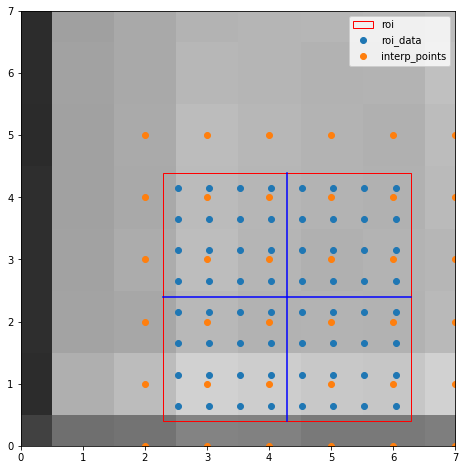

In [35]:
# The blue points are the sample points. These are the interpolated points since they do not containg the
# values. These are fractional points. The are interpolated using the four closest points. 
# We will take the case of default sampling ratio.
np.random.seed(1023)
roi_pool_width, roi_pool_height = 2, 2
roi_width, roi_height = 4, 4
feature_width, feature_height = 8, 8
# Size of each bin with the pool.
bin_size_w, bin_size_h = roi_width / roi_pool_width, roi_height / roi_pool_height 
roi_bin_grid_w, roi_bin_grid_h = 4, 4

roi_xx, roi_yy = np.meshgrid(np.arange(0, roi_height, dtype=np.float32), np.arange(0, roi_width, dtype=np.float32))
translate_x, translate_y = np.random.random()/roi_height, np.random.randn()/roi_width
roi_xx += translate_x*10
roi_yy += translate_y*10

bilinear_data_points = []
def bilinear_interpolate_points(x, y, height, width):
    if y < -1 or y > height or x < -1 or x > width:
        # out of range, so it is empty
        return (None,) * 8

    if y <= 0:
        y = 0
    if x <= 0:
        x = 0

    y_low = int(y)
    x_low = int(x)

    if y_low >= height - 1:
        y_high = y_low = height - 1
        y = float(y_low)
    else:
        y_high = y_low + 1

    if x_low >= width - 1:
        x_high = x_low = width - 1
        x = float(x_low)
    else:
        x_high = x_low + 1

    return y_low, x_low, y_high, x_high


# In the case of roi align
# What points would you be sampling.
data_points=[]
roi_start_h = roi_xx[0][0]
roi_start_w = roi_yy[0][0]
ix=0
iy=0
for ph in range(0, roi_pool_height):
    for pw in range(0, roi_pool_width):
        iy=0
        while iy < roi_bin_grid_h:
            y = roi_start_h + ph * bin_size_h + \
                (iy + .5) * bin_size_h / roi_bin_grid_h
            ix = 0
            while ix < roi_bin_grid_w:
                x = roi_start_w + pw * bin_size_w + \
                    (ix + .5) * bin_size_w / roi_bin_grid_w
                bilinear_data_points.append(bilinear_interpolate_points(x, y, feature_height, feature_width))
                data_points.append((x, y))
                ix += 1
            iy += 1

x_low = min([bd[0] for bd in bilinear_data_points])
y_low = min([bd[1] for bd in bilinear_data_points])
x_high = max([bd[2] for bd in bilinear_data_points])
y_high = max([bd[3] for bd in bilinear_data_points])
print("x_low, y_low, x_high, y_high", x_low, y_low, x_high, y_high)
bd_xx, bd_yy = np.meshgrid(np.arange(x_low, x_high+1), np.arange(y_low, y_high+1))
x = [d[0] for d in data_points]
y = [d[1] for d in data_points]
# The red box indicates the roi.
# The dashed grid represents a feature vector.
fig = plt.figure(figsize=(feature_width, feature_height))
ax = fig.gca()
ax.autoscale(False)
rect = patches.Rectangle((roi_xx[0][0], roi_yy[0][0]),4,4,linewidth=1,edgecolor='r',facecolor='none', label='roi')
ax.add_patch(rect)
ax.axvline(roi_xx[0][0]+2, c='blue', ymin=(roi_yy[0][0])/7, ymax=(roi_yy[0][0]+4)/7)
ax.axhline(roi_yy[0][0]+2, c='blue', xmin=(roi_xx[0][0])/7, xmax=(roi_xx[0][0]+4)/7)
ax.scatter(y, x, label='roi_data') # TODO: Correct this
ax.scatter(bd_xx, bd_yy, label="interp_points")
ax.set_xticks(np.arange(0, feature_width))
ax.set_yticks(np.arange(0, feature_height))
ax.legend()
plt.imshow(feat_50_1, cmap='gray')

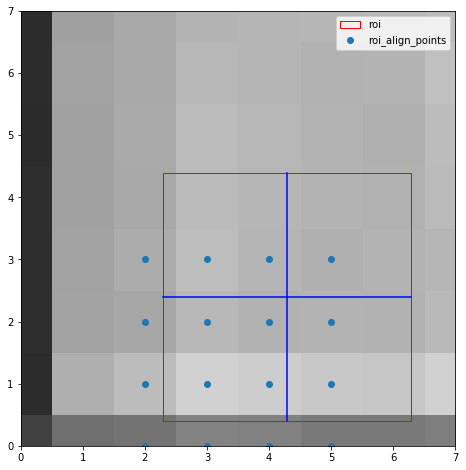

In [36]:
# Now lets look at the ROI Align. 
roi_align_points = []
roi_align_sample_points = []
roi_start_h = roi_xx[0][0]
roi_start_w = roi_yy[0][0]
roi_bin_grid_w = 2
roi_bin_grid_h = 2
for pw in range(0, roi_pool_width):
    for ph in range(0, roi_pool_height):
        start_x = roi_start_w + pw * bin_size_w
        start_y = roi_start_h + ph *bin_size_h
        end_x = roi_start_w + (pw+1) * bin_size_w
        end_y = roi_start_h + (ph+1) * bin_size_h
        roi_align_points.append((start_x,\
                       start_y,\
                       end_x,\
                       end_y
                      ))
        for ix in range(0, roi_bin_grid_w):
            for iy in range(0, roi_bin_grid_h):
                roi_align_sample_points.append((np.floor(start_x+ix), np.floor(start_y + iy)))

fig = plt.figure(figsize=(feature_width, feature_height))
ax = fig.gca()
ax.autoscale(False)
rect = patches.Rectangle((roi_xx[0][0], roi_yy[0][0]),4,4,linewidth=1,edgecolor='r',facecolor='none', label='roi')
ax.add_patch(rect)
roi_align_sample_points_x = [r[0] for r in roi_align_sample_points]
roi_align_sample_points_y = [r[1] for r in roi_align_sample_points]
ax.scatter(roi_align_sample_points_y, roi_align_sample_points_x, label='roi_align_points')
ax.axvline(roi_xx[0][0]+2, c='blue', ymin=(roi_yy[0][0])/7, ymax=(roi_yy[0][0]+4)/7)
ax.axhline(roi_yy[0][0]+2, c='blue', xmin=(roi_xx[0][0])/7, xmax=(roi_xx[0][0]+4)/7)
ax.set_xticks(np.arange(0, feature_width))
ax.set_yticks(np.arange(0, feature_height))
ax.legend()
plt.imshow(feat_50_1, cmap='gray')
# As can be clearly see with the roi align there is an alignment problem that exist 
# that comes because of the floor/ quantization issues.

# ROI Head

In [40]:
"""
The need for poolers arises because of diffrent size of the objects detected bu the rpn module.
We could give object at a time but this would essentially become very slow.
"""

feats = feat
"""
Roi Feature Extractor
Pooler(features, proposals) -- >  Resenet Head -- > roi_features
"""

# Before we feed the sampled box it is important to rember that these boxes are not 
# balanced. Meaning there is still a ratio imbalance as shown previously. Because the FG-BG
# sampler is applied to during the loss computation only. So let's balance the boxes.


if not isinstance(target, (list, )):
    target = [target]

print(proposals)
print(target)
    
# Subsample for balanced minibatches
labels, regression_targets = res_50.roi_heads.box.loss_evaluator.prepare_targets(proposals, target)
sampled_pos_inds, sampled_neg_inds = res_50.roi_heads.box.loss_evaluator.fg_bg_sampler(labels)
if isinstance (proposals, (list, )):
    proposals = list(proposals)

# add corresponding label and regression_targets information to the bounding boxes
for labels_per_image, regression_targets_per_image, proposals_per_image in zip(
    labels, regression_targets, proposals
):
    proposals_per_image.add_field("labels", labels_per_image)
    proposals_per_image.add_field(
        "regression_targets", regression_targets_per_image
    )

# distributed sampled proposals, that were obtained on all feature maps
# concatenated via the fg_bg_sampler, into individual feature map levels
for img_idx, (pos_inds_img, neg_inds_img) in enumerate(
    zip(sampled_pos_inds, sampled_neg_inds)
):
    img_sampled_inds = torch.nonzero(pos_inds_img | neg_inds_img).squeeze(1)
    proposals_per_image = proposals[img_idx][img_sampled_inds]
    proposals[img_idx] = proposals_per_image

_proposals = proposals

# now we have the balanced proposals

roi_feat = res_50.roi_heads.box.feature_extractor(feat, _proposals)
"""
Features for each of the the proposals.(I don't understand the need for using another conv here)
# NP: Numer of proposals
# C: Number of channels
# W: Feat width
# H: Feat height
"""
print(roi_feat.shape)


[BoxList(num_boxes=512, image_width=400, image_height=600, mode=xyxy)]
[BoxList(num_boxes=8, image_width=400, image_height=600, mode=xyxy)]
proposal_shape torch.Size([512, 4])
torch.Size([512, 2048, 7, 7])


In [64]:
"""
The ROI Feat's are used to predict the class scores and the bounding boxes.
Predictor N/w comprises of a AvgPool2d|->Linear(Bbox)
                                      |->Linear(Class Network)
"""

class_logits, box_regression = res_50.roi_heads.box.predictor(roi_feat)
print("class_logits.shape", class_logits.shape)
print("box_regression", box_regression.shape) # the shape here is num_feat_maps * 4 * num_classes(14)

"""
After this we again go through the NMS Layer this is required since 
we have predicted new bounding boxes delta's. 
There are only minor diffrences between the NMS layer here and RPN Network 
lets go over them.
"""




class_logits.shape torch.Size([512, 14])
box_regression torch.Size([512, 56])


"\nAfter this we again go through the NMS Layer this is required since \nwe have predicted new bounding boxes delta's. \nThere are only minor diffrences between the NMS layer here and RPN Network \nlets go over them.\n"

In [83]:
class_logits = [class_logits]
box_regression = [box_regression]
class_logits = cat(class_logits, dim=0)
box_regression = cat(box_regression, dim=0)
device = class_logits.device

proposals = _proposals

labels = cat([proposal.get_field("labels") for proposal in proposals], dim=0)
# As you can see we are predicting some what correctly for the bounding boxes.
tmp_labels = labels[torch.nonzero(labels>0).squeeze()]

for l in tmp_labels:
    # we add the zero label for background so lets ignore it
    print(coco.coco.cats[l.item()]['name'])

regression_targets = cat(
    [proposal.get_field("regression_targets") for proposal in proposals], dim=0
)

# let's look at the corresponding regression targets for them.


classification_loss = F.cross_entropy(class_logits, labels)

# get indices that correspond to the regression targets for
# the corresponding ground truth labels, to be used with
# advanced indexing
sampled_pos_inds_subset = torch.nonzero(labels > 0).squeeze(1)
labels_pos = labels[sampled_pos_inds_subset]

# The idx needs to be mapped to correct location in box_regression 
# the shape of box_reggression is [num_feat, num_class * 4]
# just think of the this mapping as if this flattened and you had to map.
# on feat lets say 12 we need to get bounding box for label 5. the first 20 positions the labels of 
# are defined by labels upto 4. We can see a disadvantage for one feat we can show that one particular 
# element once.
map_inds = 4 * labels_pos[:, None] + torch.tensor([0, 1, 2, 3], device=device)

# let's visualise one of the these feat and their corresponding the bbox's.
# TODO: Later.

box_loss = smooth_l1_loss(
    box_regression[sampled_pos_inds_subset[:, None], map_inds],
    regression_targets[sampled_pos_inds_subset],
    size_average=False,
    beta=1,
)
box_loss = box_loss / labels.numel()

print (classification_loss, box_loss)


outer
outer
outer
footwear
outer
headwear
outer
headwear
outer
outer
bag
bag
bag
bag
bag
outer
skirt
bag
scarf/tie
skirt
top
top
skirt
skirt
scarf/tie
top
top
headwear
scarf/tie
skirt
bag
footwear
footwear
top
outer
tensor(2.6367, grad_fn=<NllLossBackward>) tensor(0.1232, grad_fn=<DivBackward0>)


In [61]:
# Let's explain the filter result function.
def filter_results(boxlist, num_classes):
    score_thresh = 0.05
    nms = 0.8
    detections_per_img = 100
    # boxlist is just the proposal pridicted using the rpn which have been filtered using fg-bg sampler clip boxes etc
    # boxes have shape (num_inputs, num_classes * 4)
    boxes = boxlist.bbox.reshape(-1, num_classes * 4)
    scores = boxlist.get_field("scores").reshape(-1, num_classes)
    result = []
    # Apply threshold on detection probabilities and apply NMS
    # Skip j = 0, because it's the background class
    inds_all = scores > score_thresh
    # we apply the scores and nms threshold on per class basis. This is important and diffrent
    # from the RPN case where we had no class information. We only want same class bounding box's
    # to suppress each other. 
    for j in range(1, num_classes): 
        inds = inds_all[:, j].nonzero().squeeze(1)
        scores_j = scores[inds, j] # include only high scores
        boxes_j = boxes[inds, j * 4 : (j + 1) * 4]
        boxlist_for_class = BoxList(boxes_j, boxlist.size, mode="xyxy")
        boxlist_for_class.add_field("scores", scores_j)
        boxlist_for_class = boxlist_nms(
            boxlist_for_class, nms, score_field="scores"
        )
        num_labels = len(boxlist_for_class)
        boxlist_for_class.add_field(
            "labels", torch.full((num_labels,), j, dtype=torch.int64)
        )
        result.append(boxlist_for_class)

    result = cat_boxlist(result)
    number_of_detections = len(result)

    # Limit to max_per_image detections **over all classes**
    if number_of_detections > detections_per_img > 0:
        cls_scores = result.get_field("scores")
        image_thresh, _ = torch.kthvalue(
            cls_scores.cpu(), number_of_detections - detections_per_img + 1
        )
        keep = cls_scores >= image_thresh.item()
        keep = torch.nonzero(keep).squeeze(1)
        result = result[keep]
    return result



In [62]:
# Now we again apply the NMS algorithm it is essentially the same with few minor changes let's look
# at them.
boxes = _proposals

class_prob = F.softmax(class_logits, -1)
image_shapes = [box.size for box in boxes]
boxes_per_image = [len(box) for box in boxes]
concat_boxes = torch.cat([a.bbox for a in boxes], dim=0)

# We are still prediciting deltas
proposals = box_coder_decode(
    box_regression.view(sum(boxes_per_image), -1), concat_boxes
)

num_classes = class_prob.shape[1]

# This is diffrent. We want to split since we are evaluating loss per image.
proposals = proposals.split(boxes_per_image, dim=0)
class_prob = class_prob.split(boxes_per_image, dim=0)

results = []
for prob, boxes_per_img, image_shape in zip(
    class_prob, proposals, image_shapes
):
    # adding probability scores to each bbox
    boxes = boxes_per_img.reshape(-1, 4)
    scores = prob.reshape(-1)
    boxlist = BoxList(boxes, image_shape, mode="xyxy")
    boxlist.add_field("scores", scores)

    boxlist = boxlist.clip_to_image(remove_empty=False)
    boxlist = filter_results(boxlist, num_classes)
    results.append(boxlist)

